# set up

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import ast

results = "/home/c/dkorot/AI4GOOD/ai4good-mushroom/results/few_shot_overall_results.json"
df = pd.read_json(results)

no_prompt_results_linear = {
"shots": [0, 1, 5, 10, 20],
"top1": [0.17375432304342256, 0.14794415268348918, 0.4118099141795824, 0.4759190470090944, 0.5701934161649801],
"top5": [0.3398872806455745, 0.3710772383758166, 0.7059049570897912, 0.7857051364160369, 0.8471884206481363],
"balanced_acc": [0.11135393210618887, 0.15693212241062424, 0.3783356767488163, 0.4684481591264947, 0.555312425235222],
"macro_f1": [0.08306181843795245, 0.1292491582531643, 0.3495973688573753, 0.42815230324569564, 0.5181250407800437]}

no_prompt_results_prompt = {
"shots": [0, 1, 5, 10, 20],
"top1": [0.17375432304342256, 0.12290252337645703, 0.3493019085436147, 0.3856154732931984, 0.46407070577686693],
"top5": [0.3398872806455745, 0.3021006788779301, 0.6398104265402843, 0.6893172793646727, 0.751953375176124],
"balanced_acc": [0.11135393210618887, 0.13618880148149493, 0.3103226373911458, 0.3750403797601285, 0.44167451571645827],
"macro_f1": [0.08306181843795245, 0.11428868692647248, 0.2876809967708631, 0.34099436563777863, 0.40388063876282854]}

no_prompt_results = {"prototype": no_prompt_results_prompt, "linear": no_prompt_results_linear}

df_no_tmp = df.drop(columns=["temp", "mix_strategy"])
df_condensed = (
    df_no_tmp.groupby(['shot', 'model', 'alpha', 'prompt_set', 'lr', 'weight_decay', 'split', 'backbone'], as_index=False)
      .agg({'top1': "first", 'top5': "first", 'balanced_acc': "first", 'macro_f1': "first", 'per_class_acc': "first"})
)
df = df_condensed

In [18]:
# print the top rows of df with the highest balanced_acc for backbone 'ViT-B-32-quickgelu' and shot == 20
top_rows = df[(df['split'] == "val") & (df['backbone'] == "ViT-B-32-quickgelu")].sort_values(by='balanced_acc', ascending=False).head(5)
top_rows

,shot,model,alpha,prompt_set,lr,weight_decay,split,backbone,top1,top5,balanced_acc,macro_f1,per_class_acc
16879,100,linear+prompts,1.0,delta,0.03,0.0000,val,ViT-B-32-quickgelu,0.701012,0.922772,0.690195,0.657745,"{'Agaricus augustus': 0.52, 'Agaricus xanthode..."
16889,100,linear+prompts,1.0,delta,0.03,0.0001,val,ViT-B-32-quickgelu,0.702869,0.922772,0.687365,0.656220,"{'Agaricus augustus': 0.64, 'Agaricus xanthode..."
17019,100,linear+prompts,1.0,ensemble,0.03,0.0005,val,ViT-B-32-quickgelu,0.698642,0.921875,0.687114,0.654039,"{'Agaricus augustus': 0.58, 'Agaricus xanthode..."
17239,100,linear+prompts,1.0,v1,0.03,0.0000,val,ViT-B-32-quickgelu,0.698578,0.921875,0.686815,0.654208,"{'Agaricus augustus': 0.64, 'Agaricus xanthode..."
17259,100,linear+prompts,1.0,v1,0.03,0.0005,val,ViT-B-32-quickgelu,0.703509,0.922387,0.686753,0.654703,"{'Agaricus augustus': 0.64, 'Agaricus xanthode..."


In [19]:
final_parameters = {
    "MODEL": "linear+prompts",
    # "DEFAULT_PRETRAINED": {"PE-Core-bigG-14-448": "meta"},
    "DEFAULT_PRETRAINED": {"ViT-B-32-quickgelu": "openai"},
    "SHOTS": 100,
    "PROMPT_SET": "delta",
    "LR": 0.03,
    "WD": 0.0000,
    "SLPIT": "val"
}

In [20]:
import pandas as pd
import ast

# -------------------------------
# 1. Filter to the chosen config
# -------------------------------

chosen_cfg = {
    "shot": final_parameters["SHOTS"],
    "model": final_parameters["MODEL"],
    "prompt_set": final_parameters["PROMPT_SET"],
    "lr": final_parameters["LR"],
    "weight_decay": final_parameters["WD"],
    "split": final_parameters["SLPIT"],
    "backbone": list(final_parameters["DEFAULT_PRETRAINED"].keys())[0]
}

cfg_df = df.copy()
for k, v in chosen_cfg.items():
    cfg_df = cfg_df[cfg_df[k] == v]

if cfg_df.empty:
    raise ValueError("No runs matched the chosen configuration — verify the filters.")

# We should now only have rows where α varies.
print("Filtered rows:", len(cfg_df))
print("Available alphas:", sorted(cfg_df["alpha"].unique()))


# -----------------------------------
# 2. Parse per_class_acc dictionaries
# -----------------------------------

# per_class_acc is stored as a dict-like string, so parse it:
def parse_dict(x):
    if isinstance(x, dict):
        return x
    return ast.literal_eval(x)

cfg_df["per_class_acc_parsed"] = cfg_df["per_class_acc"].apply(parse_dict)


# -----------------------------------------------------------
# 3. For each class, find the α that gives best performance
# -----------------------------------------------------------

# class -> alpha -> metric
class_alpha_metrics = {}

for _, row in cfg_df.iterrows():
    alpha = row["alpha"]
    class_dict = row["per_class_acc_parsed"]

    for cls, acc in class_dict.items():
        class_alpha_metrics.setdefault(cls, {})
        class_alpha_metrics[cls].setdefault(alpha, [])
        class_alpha_metrics[cls][alpha].append(acc)

# Compute best alpha
best_alpha_per_class = []

for cls, alpha_dict in class_alpha_metrics.items():
    # average metric for each alpha
    alpha_mean = {alpha: sum(vals)/len(vals) for alpha, vals in alpha_dict.items()}
    # pick alpha with highest mean accuracy
    best_alpha = max(alpha_mean.items(), key=lambda x: x[1])[0]
    best_metric = alpha_mean[best_alpha]

    best_alpha_per_class.append({
        "class": cls,
        "best_alpha": best_alpha,
        "best_metric": best_metric
    })

best_alpha_df = pd.DataFrame(best_alpha_per_class).sort_values("class")

# print per row with 2 decimal digits each, sorted by best metric
for _, row in best_alpha_df.sort_values("best_metric", ascending=True).iterrows():
    print(f"Best Alpha: {row['best_alpha']:.2f}, Best Metric: {100*row['best_metric']:.2f}%, class: {row['class']} ")

# ------------------------------

Filtered rows: 6
Available alphas: [np.float64(0.0), np.float64(0.2), np.float64(0.4), np.float64(0.6000000000000001), np.float64(0.8), np.float64(1.0)]
Best Alpha: 1.00, Best Metric: 27.08%, class: Suillus luteus 
Best Alpha: 1.00, Best Metric: 33.33%, class: Tylopilus felleus 
Best Alpha: 1.00, Best Metric: 33.73%, class: Leccinum aurantiacum 
Best Alpha: 1.00, Best Metric: 43.90%, class: Armillaria borealis 
Best Alpha: 1.00, Best Metric: 44.00%, class: Amanita amerirubescens 
Best Alpha: 1.00, Best Metric: 44.74%, class: Boletus reticulatus 
Best Alpha: 1.00, Best Metric: 44.90%, class: Armillaria mellea 
Best Alpha: 1.00, Best Metric: 46.51%, class: Paxillus involutus 
Best Alpha: 1.00, Best Metric: 47.22%, class: Psathyrella candolleana 
Best Alpha: 1.00, Best Metric: 47.50%, class: Amanita rubescens 
Best Alpha: 1.00, Best Metric: 47.69%, class: Leccinum versipelle 
Best Alpha: 1.00, Best Metric: 47.92%, class: Boletus pallidus 
Best Alpha: 1.00, Best Metric: 48.00%, class: Phel

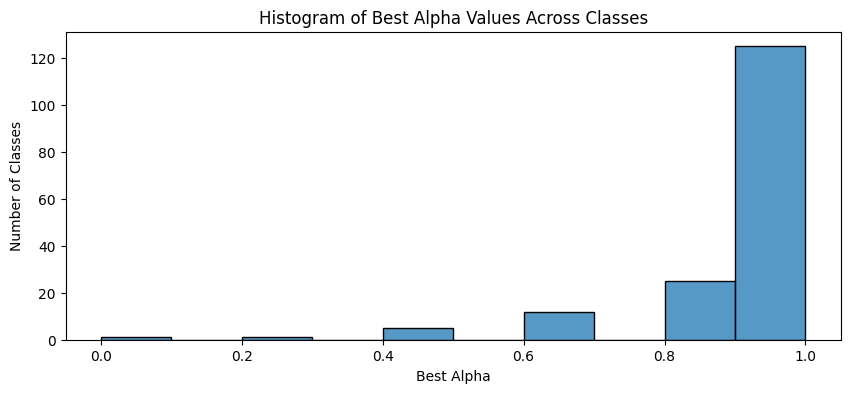

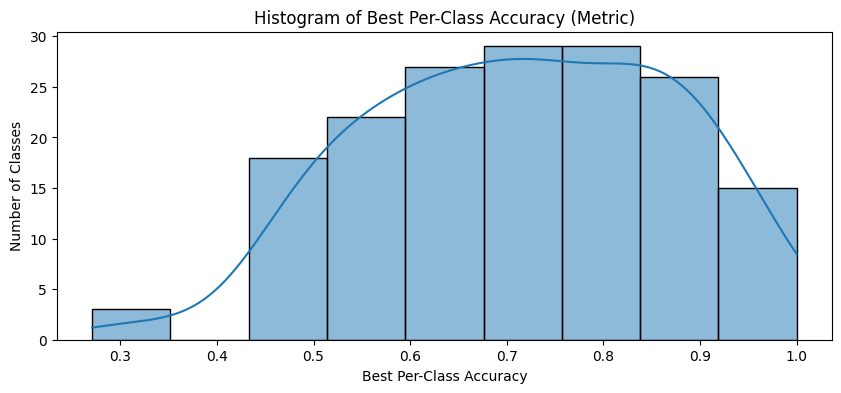

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# Histogram of best alphas
# ----------------------------
plt.figure(figsize=(10, 4))
sns.histplot(best_alpha_df["best_alpha"], kde=False, bins=10)
plt.title("Histogram of Best Alpha Values Across Classes")
plt.xlabel("Best Alpha")
plt.ylabel("Number of Classes")
plt.show()


# ----------------------------
# Histogram of best per-class metrics
# ----------------------------
plt.figure(figsize=(10, 4))
sns.histplot(best_alpha_df["best_metric"], kde=True)
plt.title("Histogram of Best Per-Class Accuracy (Metric)")
plt.xlabel("Best Per-Class Accuracy")
plt.ylabel("Number of Classes")
plt.show()


In [22]:
# out put into a jason file as a dictionary of class -> best_alpha
best_alpha_dict = {row['class']: row['best_alpha'] for _, row in best_alpha_df.iterrows()}
best_alpha_dict_file = "/home/c/dkorot/AI4GOOD/ai4good-mushroom/results/best_alpha_b32.json"
pd.Series(best_alpha_dict).to_json(best_alpha_dict_file)
print(f"Best alpha per class saved to {best_alpha_dict_file}")

Best alpha per class saved to /home/c/dkorot/AI4GOOD/ai4good-mushroom/results/best_alpha_b32.json


In [ ]:
import pandas as pd

# df = your dataframe
# Example: df = pd.read_csv("results.csv") or loaded from JSON

best_alpha_per_class = {}
i=0
for cls in set().union(*df["per_class_acc"].apply(lambda d: d.keys())):
    i+=1; print(i)
    # Filter rows where this class is present (should be all)
    sub = df.copy()

    # Extract accuracy of this class for each row
    sub["acc_cls"] = sub["per_class_acc"].apply(lambda d: d.get(cls, float("nan")))

    # ------- Best per-class accuracy -------
    idx_best_acc = sub["acc_cls"].idxmax()
    best_alpha_acc = sub.loc[idx_best_acc, "alpha"]
    best_value_acc = sub.loc[idx_best_acc, "acc_cls"]

    # ------- Best macro-F1 (using overall macro_f1 column) -------
    # idx_best_f1 = sub["macro_f1"].idxmax()
    # best_alpha_f1 = sub.loc[idx_best_f1, "alpha"]
    # best_value_f1 = sub.loc[idx_best_f1, "macro_f1"]

    # Store
    best_alpha_per_class[cls] = best_alpha_acc
    # records.append({
    #     "class_name": cls,
    #     "best_alpha_per_class_acc": best_alpha_acc,
    #     "best_value_per_class_acc": best_value_acc,
    #     # "best_alpha_macro_f1": best_alpha_f1,
    #     # "best_macro_f1_value": best_value_f1
    # })

# Final table
# result_df = pd.DataFrame(best_alpha_per_class)

print(best_alpha_per_class)
# export tp json
import json
with open("best_alpha_per_class.json", "w") as f:
    json.dump(best_alpha_per_class, f)


In [ ]:
# Keys that define a unique configuration *except* temperature
group_keys = [
    "shot", "model", "alpha", "prompt_set",
    "lr", "weight_decay", "mix_strategy",
    "split", "backbone"
]

metric_cols = ["top1", "top5", "balanced_acc", "macro_f1"]

changed_any = False

print("\nChecking all configurations for temperature effects...\n")

for cfg, group in df.groupby(group_keys):
    # If only one temp value, skip
    if group["temp"].nunique() <= 1:
        continue
    
    # Compare metrics across temps
    metrics_across_temps = group[metric_cols].drop_duplicates()

    if len(metrics_across_temps) > 1:
        changed_any = True
        print("\n⚠️ Temperature *affects* results for config:\n")
        for k, v in zip(group_keys, cfg):
            print(f"  {k}: {v}")
        print("\nDifferent outputs:")
        print(metrics_across_temps)
        print("-" * 60)

if not changed_any:
    print("✅ Temperature does NOT affect any results across all configurations!")

In [ ]:
# Collapse rows that differ only by `temp` when metrics are similar
def collapse_temp_rows(df, group_keys, metric_cols, time_col='time', time_agg='min', rtol=1e-3, atol=1e-6):
    """Return a new DataFrame where rows that differ only by `temp`
    are collapsed when metric values are similar.
    - group_keys: list of keys used to identify unique configs (include 'temp' originally)
    - metric_cols: list of metric column names to compare
    - time_col: column name containing runtime/time to aggregate
    - time_agg: 'min'|'mean'|'median' to aggregate time
    - rtol/atol: tolerances for np.isclose comparison
    """
    key_list = [k for k in group_keys if k != 'temp' and k != time_col]
    out = []
    collapsed = 0
    for _, grp in df.groupby(key_list):
        # If there's only one temp, just keep the rows
        if grp['temp'].nunique() <= 1:
            out.extend(grp.to_dict(orient='records'))
            continue
        # Compare metric rows to their mean across temps
        arr = grp[metric_cols].to_numpy(dtype=float)
        mean = arr.mean(axis=0)
        close = np.all(np.isclose(arr, mean, rtol=rtol, atol=atol), axis=1)
        if close.all():
            # collapse: take first row as template and aggregate fields
            row = grp.iloc[0].copy()
            row['temp'] = ','.join(map(str, sorted(grp['temp'].unique())))
            if time_col in grp.columns:
                if time_agg == 'min':
                    row[time_col] = float(grp[time_col].min())
                elif time_agg == 'mean':
                    row[time_col] = float(grp[time_col].mean())
                else:
                    row[time_col] = float(grp[time_col].median())
            out.append(row.to_dict())
            collapsed += len(grp) - 1
        else:
            # keep all rows if metrics vary across temps
            out.extend(grp.to_dict(orient='records'))
    print(f'Collapsed {collapsed} rows into their temperature-equivalent representatives')
    return pd.DataFrame(out)

# Example usage: adjust rtol/atol to control how similar metrics must be to collapse
collapsed_df = collapse_temp_rows(df, group_keys, metric_cols, time_col='time', time_agg='min', rtol=1e-3)
print('Original rows:', len(df), '-> After collapse:', len(collapsed_df))
# To replace `df` for downstream plotting uncomment the next line:
# df = collapsed_df

In [ ]:
# combo_cols = [
#     "model", "alpha", "temp", "prompt_set", "lr", "weight_decay", "mix_strategy", "backbone", "shot"
# ]

# res = []

# for idx, row in df.iterrows():
#     print(f"Processing row {idx+1}/{len(df)}")
#     per_class = row["per_class_acc"]
#     combo = tuple(row[c] for c in combo_cols)
    
#     for cls, acc in per_class.items():
#         res.append({
#             "class": cls,
#             "accuracy": acc,
#             **{c: row[c] for c in combo_cols}
#         })

# long_df = pd.DataFrame(res)

# idx = long_df.groupby("class")["accuracy"].idxmax()
# best_per_class = long_df.loc[idx].reset_index(drop=True)

# for _, r in best_per_class.iterrows():
#     print(f"Class: {r['class']}")
#     print(f"  Highest accuracy: {r['accuracy']:.4f}")
#     print("  Best combination:")
#     for c in combo_cols:
#         print(f"    {c}: {r[c]}")
#     print("-" * 60)


In [ ]:
# row = df[
#     (df["model"] == "linear+prompts") &
#     (df["alpha"] == 0.2) &
#     (df["temp"] == 1) &
#     (df["prompt_set"] == "ensemble") &
#     (df["lr"] == 0.0001) &
#     (df["weight_decay"] == 0.0005) &
#     (df["mix_strategy"] == "none") &
#     (df["split"] == "val") &
#     (df["backbone"] == "PE-Core-bigG-14-448")
# ]

# print(row)


In [ ]:
# freqs = {}

# for col in combo_cols:    freqs[col] = best_per_class[col].value_counts()

# for col in combo_cols:
#     print(f"\n=== Frequency for {col} ===")
#     print(freqs[col].to_string())


In [ ]:
# # {splits:
# #       {backbones:
# #             {shots: 
# #                   {models:
# #                        {accuracy_types: value}}}}
# splits = ['val', 'test']
# backbones = ['PE-Core-bigG-14', 'ViT-B-32', 'ViT-B-16', 'ViT-L-14', 'ViT-gopt-16', 'ViT-H-14']
# shots = [0, 1, 5, 10, 20, 50, 100]
# models = ['prototype', 'linear']  # model types
# accuracy_types = ['top1', 'top5', 'balanced_acc', 'macro_f1']  # accuracy metrics

# results_dict = {}

# for split in splits:
#     print(split)
#     results_dict[split] = {}
#     for acc_type in accuracy_types:
#         results_dict[split][acc_type] = {}
#         print("     "+ str(acc_type))
#         for shot in shots:
#             print("         " + str(shot))
#             results_dict[split][acc_type][shot]= {}
#             for backbone in backbones:
#                 print("             " + str(backbone))
#                 results_dict[split][acc_type][shot][backbone] = {}
#                 for model in models:
#                     print("                     " + str(model))
#                     results_dict[split][acc_type][shot][backbone][model] = {}
                    
#                     # rows = df[
#                     #     (df["split"] == split) &
#                     #     (df['backbone'].str.contains(backbone)) &
#                     #     (df["shot"] == shot) &
#                     #     df["model"].str.startswith(model) | (df["model"] == "zero-shot")
#                     # ]
#                     rows = df[
#                                 (df["split"] == split) &
#                                 (df['backbone'].str.contains(backbone)) &
#                                 (df["shot"] == shot) &
#                                 (
#                                     (df["model"].str.startswith(model)) |
#                                     (df["model"] == "zero-shot")
#                                 )
#                             ]

#                     idx = rows[acc_type].idxmax()
#                     best_row = rows.loc[idx]
#                     print(f"                            best alpha: {best_row['alpha']}, best {acc_type}: {best_row[acc_type]}")
#                     results_dict[split][acc_type][shot][backbone][model] = {
#                         "best_alpha": float(best_row["alpha"]),
#                         "best_value": float(best_row[acc_type]),
#                     }

# # print(results_dict)

# import json

# with open('best_alphas.json', 'w') as f:
#     json.dump(results_dict, f)



In [ ]:
# # {splits:
# #       {backbones:
# #             {shots: 
# #                   {models:
# #                        {accuracy_types: value}}}}
# splits = ['val', 'test']
# backbones = ['PE-Core-bigG-14', 'ViT-B-32', 'ViT-B-16', 'ViT-L-14', 'ViT-gopt-16', 'ViT-H-14']
# shots = [0, 1, 5, 10, 20, 50, 100]
# models = ['prototype+', 'linear+']  # model types
# accuracy_types = ['top1', 'top5', 'balanced_acc', 'macro_f1']  # accuracy metrics

# results_dict_op = {}

# for split in splits:
#     print(split)
#     results_dict_op[split] = {}
#     for acc_type in accuracy_types:
#         results_dict_op[split][acc_type] = {}
#         print("     "+ str(acc_type))
#         for shot in shots:
#             print("         " + str(shot))
#             results_dict_op[split][acc_type][shot]= {}
            
#             rows = df[(df["split"] == split) & (df["shot"] == shot)]

#             idx = rows[acc_type].idxmax()
#             best_row = rows.loc[idx]

#             print(f"             best backbone: {best_row['backbone']}, best model: {best_row['model']}")

#             print(f"                    best alpha: {best_row['alpha']}, best {acc_type}: {best_row[acc_type]}")
#             results_dict_op[split][acc_type][shot] = {
#                 "best_backbone": best_row['backbone'],
#                 "best_model": best_row['model'],
#                 "best_alpha": float(best_row["alpha"]),
#                 "best_value": float(best_row[acc_type]),
#             }


In [ ]:

# # Example lists for looping
# backbones = ['PE-Core-bigG-14', 'ViT-B-32', 'ViT-B-16', 'ViT-L-14', 'ViT-gopt-16', 'ViT-H-14']
# splits = ['val', 'test']
# models = ['prototype', 'linear']  # model types
# accuracy_types = ['top1', 'top5', 'balanced_acc', 'macro_f1']  # accuracy metrics

               
# for split in splits:
#     for backbone in backbones:
#         for model in models:
#             for accuracy_type in accuracy_types:
#                 # Filter dataframe
#                 plot_df = df[
#                     (df['split'] == split) &
#                     (df['model'].str.contains(model, regex=False)) &
#                     (df['backbone'].str.contains(backbone))
#                 ]
#                 if plot_df.empty:
#                     continue  # skip if no data for this config

#                 print(plot_df)

#                 # Plot
#                 plt.figure(figsize=(10,6))
#                 sns.lineplot(
#                     data=plot_df,
#                     x='shot',
#                     y=accuracy_type,
#                     hue='alpha',
#                     markers=True,
#                     dashes=False,
#                     palette="viridis"
#                 )

#                 # plot baseline
#                 zeroShot_value = df.loc[(df["model"] == "zero-shot") & (df["split"] == split) & (df["backbone"].str.contains(backbone, case=False, na=False)), accuracy_type].values
#                 # plt.plot([0], [zeroShot_value], marker='x', linestyle='--', color='red', label='zero_shot with prompt')
#                 plt.plot(no_prompt_results[model]["shots"], no_prompt_results[model][accuracy_type], marker='x', linestyle='--', color='black', label='baseline B-32 no-prompt')

#                 plt.xscale('log')
#                 plt.xlim(-5, 105)

#                 plt.title(f"{backbone} {model}: {accuracy_type} Accuracy vs Shots ({split})")
#                 plt.ylabel(f"{accuracy_type} Accuracy")
#                 plt.xlabel("Shots")
#                 plt.legend(title="Alpha", bbox_to_anchor=(1.05, 1), loc='upper left')
#                 plt.tight_layout()
#                 plt.show()



# plot

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Example lists for looping
splits = ['val'] #, 'test']
models = ['prototype', 'linear']  # model types
backbones = ['PE-Core-bigG-14-448']# ['ViT-B-32', 'ViT-B-16', 'ViT-L-14', 'ViT-gopt-16', 'ViT-H-14']
accuracy_types = ['top1', 'top5', 'balanced_acc', 'macro_f1']  # accuracy metrics

               
for split in splits:
    for backbone in backbones:
        for model in models:
            for accuracy_type in accuracy_types:
                # Filter dataframe
                plot_df = df[
                    (df['split'] == split) &
                    (df['model'].str.contains(model, regex=False)) &
                    (df['backbone'].str.contains(backbone))
                ]
                if plot_df.empty:
                    continue  # skip if no data for this config

                print(plot_df)

                # Plot
                plt.figure(figsize=(10,6))
                sns.lineplot(
                    data=plot_df,
                    x='shot',
                    y=accuracy_type,
                    hue='alpha',
                    markers=True,
                    dashes=False,
                    palette="viridis"
                )

                # plot baseline
                zeroShot_value = df.loc[(df["model"] == "zero-shot") & (df["split"] == split) & (df["backbone"].str.contains(backbone, case=False, na=False)), accuracy_type].values
                # plt.plot([0], [zeroShot_value], marker='x', linestyle='--', color='red', label='zero_shot with prompt')
                plt.plot(no_prompt_results[model]["shots"], no_prompt_results[model][accuracy_type], marker='x', linestyle='--', color='black', label='baseline B-32 no-prompt')

                plt.xscale('log')
                plt.xlim(-5, 105)

                plt.title(f"{backbone} {model}: {accuracy_type} Accuracy vs Shots ({split})")
                plt.ylabel(f"{accuracy_type} Accuracy")
                plt.xlabel("Shots")
                plt.legend(title="Alpha", bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.tight_layout()
                plt.show()

